#### Importación de Librerías y Módulos Necesarios

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
from sklearn.metrics import classification_report, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import time
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import os
import warnings
import re
# Suprimir el warning relacionado con PyDataset
warnings.filterwarnings(
    "ignore", 
    message=re.escape("Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor.")
)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, label_binarize, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from tensorflow.keras.applications.densenet import preprocess_input
import seaborn as sns
import pandas as pd
from PIL import Image, UnidentifiedImageError, ImageTk
import logging
logging.getLogger("radiomics").setLevel(logging.ERROR) 
import radiomics
import SimpleITK as sitk
import tempfile
import random
from sklearn.neighbors import NearestCentroid
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import tkinter as tk
from tkinter import ttk, messagebox, filedialog
import tkinter.font as tkFont
import threading
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
import sys
import pkgutil
import inspect

#### Exploración del Directorio de Imágenes

En esta sección se define y ejecuta una función para explorar la estructura del directorio que contiene el dataset.  
La función:  
- Verifica la existencia del directorio.  
- Recorre y cuenta subdirectorios (se asume que cada uno representa una clase) y archivos.  
- Muestra un resumen de la cantidad de subcarpetas y archivos, además de detalles por cada subdirectorio.  
Esto permite confirmar que la estructura del dataset es la esperada antes de proceder.

In [24]:
# Define la ruta del directorio
directory = 'Lung Disease Dataset/train'

def explore_directory(directory):
    """
    Función para explorar el contenido de un directorio y proporcionar información.
    """
    if not os.path.exists(directory):
        print(f"El directorio {directory} no existe.")
        return
    
    print(f"Explorando el contenido de: {directory}\n")
    
    # Inicialización de contadores
    num_dirs = 0
    num_files = 0
    dir_details = []
    
    # Recorre el directorio
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            num_dirs += 1
            # Cuenta los archivos en cada subdirectorio
            num_files_in_dir = len([f for f in os.listdir(item_path) if os.path.isfile(os.path.join(item_path, f))])
            dir_details.append((item, num_files_in_dir))
        elif os.path.isfile(item_path):
            num_files += 1

    # Muestra el resumen
    print(f"Resumen:\n- Total de directorios: {num_dirs}\n- Total de archivos: {num_files}\n")
    
    # Muestra información detallada de cada subdirectorio
    if dir_details:
        print("Detalles de los directorios:")
        for dir_name, file_count in dir_details:
            print(f"  - {dir_name}: {file_count} archivos")
    else:
        print("No se encontraron subdirectorios.")
    
    # Lista los archivos en el directorio raíz, si existen
    root_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    if root_files:
        print("\nArchivos en el directorio raíz:")
        for file in root_files:
            print(f"  - {file}")

# Llama a la función para explorar el directorio
explore_directory(directory)

Explorando el contenido de: Lung Disease Dataset/train

Resumen:
- Total de directorios: 5
- Total de archivos: 0

Detalles de los directorios:
  - Bacterial Pneumonia: 1205 archivos
  - Corona Virus Disease: 1218 archivos
  - Normal: 1207 archivos
  - Tuberculosis: 1220 archivos
  - Viral Pneumonia: 1204 archivos


#### Carga de Imágenes y Recopilación de Metadatos

Esta sección define una función para cargar todas las imágenes del dataset (incluyendo subdirectorios) y extraer metadatos relevantes, como:  
- Nombre de archivo.  
- Formato de la imagen.  
- Dimensiones.  
La función también gestiona excepciones para omitir imágenes corruptas o en formatos no soportados, y finalmente, imprime un resumen con ejemplos de metadatos extraídos.

In [25]:
# Define la ruta del directorio
directory_path = 'Lung Disease Dataset/train'

def load_images_from_directory(directory_path):
    """
    Carga todos los archivos de imagen desde un directorio y sus subdirectorios
    sin mantener las imágenes abiertas en memoria para evitar errores de demasiados archivos abiertos.
    """
    supported_formats = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
    metadata = []
    
    # Recorre la estructura del directorio
    for root, _, files in os.walk(directory_path):
        for file_name in files:
            if file_name.lower().endswith(supported_formats):
                image_path = os.path.join(root, file_name)
                try:
                    # Abre la imagen, extrae la información y la cierra inmediatamente
                    with Image.open(image_path) as image:
                        metadata.append({
                            'file_name': file_name,
                            'path': image_path,
                            'format': image.format,
                            'size': image.size
                        })
                except UnidentifiedImageError:
                    print(f"Omitiendo imagen no soportada o corrupta: {file_name}")
                except Exception as e:
                    print(f"Error al cargar la imagen {file_name}: {e}")
    
    return metadata


# Carga los metadatos sin mantener las imágenes en memoria
metadata = load_images_from_directory(directory_path)

# Muestra un resumen de los metadatos
if metadata:
    print(f"Total de imágenes cargadas: {len(metadata)}\n")
    print("Metadatos de ejemplo para las primeras 5 imágenes:")
    for i, meta in enumerate(metadata[:5], 1):
        print(f"  {i}. Archivo: {meta['file_name']} | Formato: {meta['format']} | Tamaño: {meta['size']}")

else:
    print("No se encontraron imágenes válidas en el directorio.")

Total de imágenes cargadas: 6054

Metadatos de ejemplo para las primeras 5 imágenes:
  1. Archivo: 1.jpeg | Formato: JPEG | Tamaño: (400, 300)
  2. Archivo: 10.jpeg | Formato: JPEG | Tamaño: (400, 300)
  3. Archivo: 117.jpeg | Formato: JPEG | Tamaño: (400, 300)
  4. Archivo: 118.jpeg | Formato: JPEG | Tamaño: (400, 300)
  5. Archivo: 12.jpeg | Formato: JPEG | Tamaño: (400, 300)


#### Creación de Generadores de Datos para Entrenamiento y Validación

Se utiliza `ImageDataGenerator` para preparar los datos de entrenamiento y validación:  
- Se establece un `validation_split` del 20%.  
- Se especifica el tamaño de las imágenes (240x240 píxeles) y el modo de clasificación (categórico).  
Esto transforma las imágenes en un formato adecuado para el entrenamiento del modelo.

In [26]:
datagen = ImageDataGenerator(validation_split=0.2)

train_dataset = datagen.flow_from_directory(
    "Lung Disease Dataset/train",
    target_size=(240, 240),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_dataset = datagen.flow_from_directory(
    "Lung Disease Dataset/train",
    target_size=(240, 240),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

# Información detallada
print("\n Resumen de la Carga de Datos:")
print(f" División de datos:")
print(f"   - Conjunto de entrenamiento: {train_dataset.samples} imágenes")
print(f"   - Conjunto de validación: {val_dataset.samples} imágenes")
print(f"   - Proporción entrenamiento-validación: {round(train_dataset.samples / (train_dataset.samples + val_dataset.samples) * 100, 2)}% - {round(val_dataset.samples / (train_dataset.samples + val_dataset.samples) * 100, 2)}%")

Found 4845 images belonging to 5 classes.
Found 1209 images belonging to 5 classes.

 Resumen de la Carga de Datos:
 División de datos:
   - Conjunto de entrenamiento: 4845 imágenes
   - Conjunto de validación: 1209 imágenes
   - Proporción entrenamiento-validación: 80.03% - 19.97%


#### Visualización de la Distribución de Clases

En esta sección se define una función que:  
- Calcula la distribución de las clases en los conjuntos de entrenamiento y validación.  
- Genera gráficos de barras para visualizar la cantidad de imágenes por clase en cada subconjunto.  
Esta visualización ayuda a identificar posibles desbalances que puedan afectar el rendimiento del modelo.


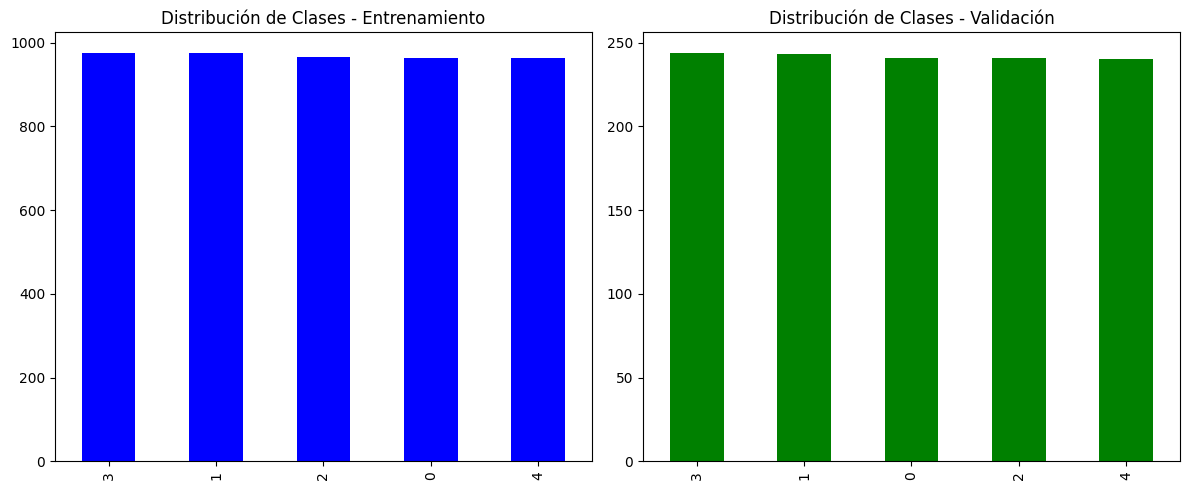

In [27]:
def plot_class_distribution(train_dataset, val_dataset):
    # Distribución de clases para entrenamiento
    train_counts = pd.Series(train_dataset.classes).value_counts()

    # Distribución de clases para validación
    val_counts = pd.Series(val_dataset.classes).value_counts()

    # Graficar
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    train_counts.plot(kind='bar', ax=ax[0], title='Distribución de Clases - Entrenamiento', color='blue')
    val_counts.plot(kind='bar', ax=ax[1], title='Distribución de Clases - Validación', color='green')
    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
plot_class_distribution(train_dataset, val_dataset)


#### Configuración de Parámetros y Definición de la Entrada del Modelo

Se establecen los parámetros fundamentales para el entrenamiento, tales como:  
- **Tamaño de Imagen:** 240x240 píxeles.  
- **Batch Size:** Número de imágenes procesadas en paralelo.  
- **Número de Épocas:** Iteraciones para el entrenamiento.  
Además, se define la forma de entrada que utilizará el modelo EfficientNetB1.

In [28]:
# Definir parámetros
image_size = (240, 240)  # Tamaño de entrada correcto para EfficientNetB1
batch_size = 32
num_epochs = 40

# Definir la forma de entrada para EfficientNet-B1
image_input = Input(shape=(240, 240, 3))

#### Construcción del Modelo Usando EfficientNetB1 y Capas Personalizadas

Esta sección carga EfficientNetB1 (sin la capa superior) y añade capas personalizadas para la clasificación, entre ellas:  
- **GlobalAveragePooling2D:** Para reducir la dimensionalidad espacial.  
- **Dense y Dropout:** Para extraer características relevantes y evitar el sobreajuste.  
- **Capa de Salida Softmax:** Para clasificar en 5 clases de enfermedades pulmonares.  
Se crea un modelo final que combina la potencia del modelo preentrenado con capas específicas para el problema.


In [29]:
# Cargar EfficientNet-B1 sin la capa superior de clasificación
efficientnet_model = EfficientNetB1(weights='imagenet', include_top=False, input_tensor=image_input)

# Agregar capas personalizadas para clasificación
x = efficientnet_model.output
x = GlobalAveragePooling2D()(x)  # Capa de pooling global
x = Dense(256, activation='relu', name="features")(x)  # Capa completamente conectada con activación ReLU
x = Dropout(0.5)(x)  # Capa de Dropout para regularización
output = Dense(5, activation='softmax')(x)  # Capa de salida para 5 clases (enfermedades pulmonares)

# Crear el modelo
model = Model(inputs=image_input, outputs=output)

#### Compilación y Entrenamiento del Modelo

Aquí se compila el modelo con:  
- **Optimizador Adam** y **Categorical Crossentropy** como función de pérdida.  
Se configuran generadores de datos con aumento y preprocesamiento, y se definen varios callbacks, tales como:  
- **ReduceLROnPlateau:** Ajuste de la tasa de aprendizaje.  
- **ModelCheckpoint:** Guardado del mejor modelo.  
- **EarlyStopping:** Finalización temprana del entrenamiento si no hay mejoras.  
Finalmente, se entrena el modelo y se almacena el historial para análisis posterior.

In [30]:
# Definir el optimizador
optimizer = Adam(learning_rate=0.001)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Crear un generador de datos para aumento de datos y normalización (preprocesamiento)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Crear un generador de datos para el conjunto de validación
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Cargar los datos de entrenamiento
train_dataset = train_datagen.flow_from_directory(
    'Lung Disease Dataset/train',
    target_size=image_size,  # Redimensiona las imágenes para que coincidan con la forma de entrada del modelo
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Cargar los datos de validación
val_dataset = val_datagen.flow_from_directory(
    'Lung Disease Dataset/val',
    target_size=image_size,  # Redimensiona las imágenes para que coincidan con la forma de entrada del modelo
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Callback para reducir la tasa de aprendizaje si la métrica de validación se estanca
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Callback para guardar el modelo con mejor precisión en validación
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Callback de EarlyStopping para detener el entrenamiento si no hay mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Si deseas seguir utilizando tu función de scheduler, la puedes incluir también
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

# Entrenar el modelo y almacenar el historial
history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[reduce_lr, checkpoint, early_stopping, lr_scheduler]
)


Found 6054 images belonging to 5 classes.
Found 2016 images belonging to 5 classes.

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/40
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7028 - loss: 0.7451
Epoch 1: val_accuracy improved from -inf to 0.20387, saving model to best_model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 770s 4s/step - accuracy: 0.7031 - loss: 0.7443 - val_accuracy: 0.2039 - val_loss: 6.7535 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/40
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8403 - loss: 0.4018
Epoch 2: val_accuracy did not improve from 0.20387
190/190 ━━━━━━━━━━━━━━━━━━━━ 589s 3s/step - accuracy: 0.8403 - loss: 0.4017 - val_accuracy: 0.1974 - val_loss: 1.7769 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/40
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8548 - loss: 0.3501


#### Visualización de las Métricas de Entrenamiento y Validación

Se define y utiliza una función para graficar:  
- La evolución de la **precisión** y **pérdida** durante el entrenamiento y validación.  
- Las métricas se presentan en un mismo gráfico para facilitar la comparación y análisis del comportamiento del modelo a lo largo de las épocas.


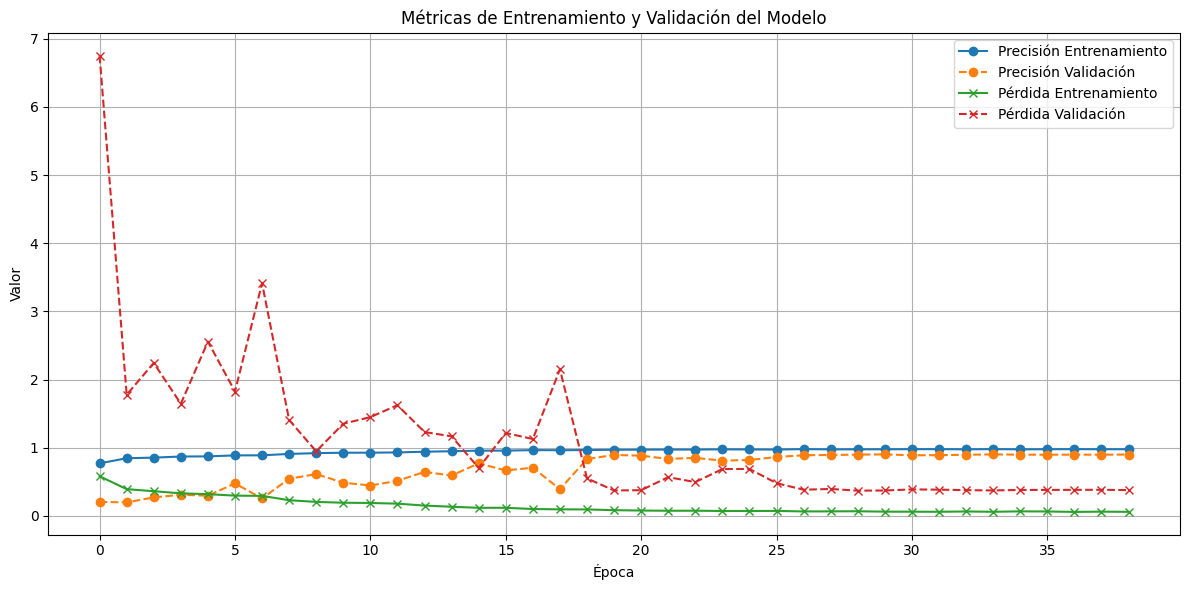

In [31]:
def plot_combined_history(history):

    plt.figure(figsize=(12, 6))

    # Graficar precisión
    plt.plot(history.history['accuracy'], label='Precisión Entrenamiento', linestyle='-', marker='o')
    plt.plot(history.history['val_accuracy'], label='Precisión Validación', linestyle='--', marker='o')

    # Graficar pérdida
    plt.plot(history.history['loss'], label='Pérdida Entrenamiento', linestyle='-', marker='x')
    plt.plot(history.history['val_loss'], label='Pérdida Validación', linestyle='--', marker='x')

    # Agregar título y etiquetas
    plt.title('Métricas de Entrenamiento y Validación del Modelo')
    plt.xlabel('Época')
    plt.ylabel('Valor')
    
    # Agregar leyenda
    plt.legend(loc='best')

    # Mostrar la cuadrícula
    plt.grid(True)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

# Graficar las métricas combinadas
plot_combined_history(history)

#### Preparación del Conjunto de Datos de Prueba

Se crea un generador de datos para el conjunto de prueba, asegurando:  
- El preprocesamiento adecuado y redimensionamiento de las imágenes.  
- Que el orden de las imágenes y etiquetas se mantenga sin aleatorización para facilitar la evaluación.  
Esto permite evaluar el rendimiento del modelo en datos no vistos.


In [32]:
# Evaluar el modelo en los datos de prueba
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_dataset = test_datagen.flow_from_directory(
    'Lung Disease Dataset/test',
    target_size=image_size,  # Redimensiona las imágenes para que coincidan con la forma de entrada del modelo
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Asegura que el orden de las predicciones coincida con el de las etiquetas reales
)

Found 2025 images belonging to 5 classes.


#### Visualización de la Evolución de la Tasa de Aprendizaje

En esta sección se define una función que:  
- Grafica la variación de la tasa de aprendizaje a lo largo de las épocas, utilizando un scheduler definido.  
Esta visualización es útil para confirmar que la estrategia de ajuste de la tasa de aprendizaje se está aplicando correctamente.


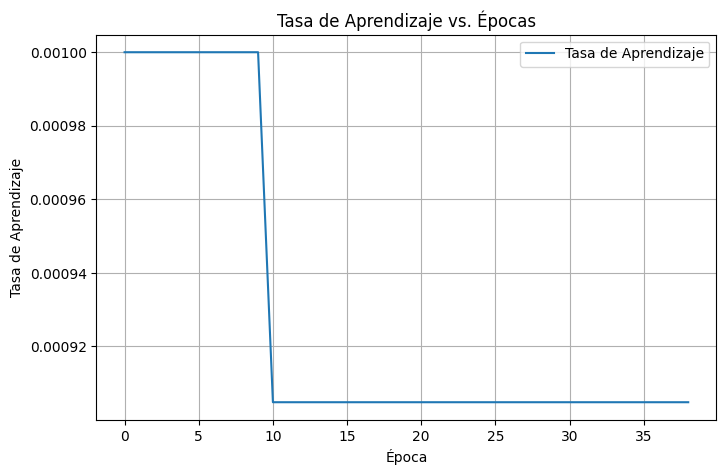

In [33]:
def plot_learning_rate(history, scheduler_fn):
    epochs = range(len(history.history['loss']))
    lr = [scheduler_fn(epoch, 0.001) for epoch in epochs]  # Ajusta la tasa de aprendizaje inicial si es necesario
    
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, lr, label='Tasa de Aprendizaje')
    plt.title('Tasa de Aprendizaje vs. Épocas')
    plt.xlabel('Época')
    plt.ylabel('Tasa de Aprendizaje')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Ejemplo de uso
plot_learning_rate(history, scheduler)

#### Visualización de la Diferencia entre Precisión de Entrenamiento y Validación

Se calcula la diferencia (delta) entre la precisión en el entrenamiento y validación para cada época, y se grafica:  
- Esto ayuda a identificar si el modelo está sufriendo sobreajuste o subajuste.  
La comparación visual de las diferencias facilita la interpretación de la capacidad de generalización del modelo.


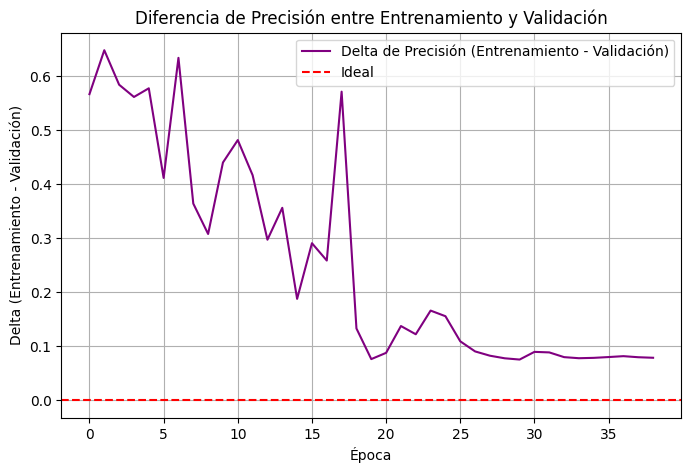

In [34]:
def plot_accuracy_delta(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    delta = [train - val for train, val in zip(train_accuracy, val_accuracy)]

    plt.figure(figsize=(8, 5))
    plt.plot(delta, label='Delta de Precisión (Entrenamiento - Validación)', color='purple')
    plt.axhline(y=0, color='r', linestyle='--', label='Ideal')
    plt.title('Diferencia de Precisión entre Entrenamiento y Validación')
    plt.xlabel('Época')
    plt.ylabel('Delta (Entrenamiento - Validación)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Usar para analizar la capacidad de generalización.
plot_accuracy_delta(history)

#### Evaluación del Modelo, Predicciones y Reporte de Clasificación

Esta sección realiza los siguientes pasos:  
- Carga el mejor modelo guardado durante el entrenamiento.  
- Evalúa el modelo en el conjunto de prueba, calculando pérdida y precisión.  
- Genera predicciones y un **classification report** detallado.  
- Guarda las etiquetas verdaderas y predichas para análisis posteriores.  
Esto permite una evaluación cuantitativa del desempeño del modelo en datos no vistos.


In [46]:
# Cargar el mejor modelo guardado durante el entrenamiento
best_model = tf.keras.models.load_model("best_model.keras")

# Vemos un resumen del mejor modelo
best_model.summary()

# Evaluar el mejor modelo en los datos de prueba
start_time = time.time()
evaluation_result = best_model.evaluate(test_dataset)
print("Tiempo de evaluación del modelo: " + str(time.time() - start_time))

# Imprimir los resultados de la evaluación
print("Pérdida en Test:", evaluation_result[0])
print("Precisión en Test:", evaluation_result[1])

# Realizar predicciones en el conjunto de prueba usando el mejor modelo
y_pred = best_model.predict(test_dataset)
y_pred_bool = np.argmax(y_pred, axis=1)

# Obtener las etiquetas verdaderas directamente desde test_dataset
true_labels = test_dataset.labels

# Obtener los nombres de las clases, usando el diccionario de train_dataset o el de respaldo
try:
    class_names = {v: k for k, v in train_dataset.class_indices.items()}
except Exception:
    class_names = {
        0: "Normal",
        1: "Bacterial pneumonia",
        2: "Viral pneumonia",
        3: "Tuberculosis",
        4: "Corona virus disease"
    }

# Generar una lista de nombres de clases ordenada por índice
target_names = [class_names[i] for i in sorted(class_names.keys())]

# Imprimir el reporte de clasificación usando los nombres de clase
print(classification_report(true_labels, y_pred_bool, digits=4, target_names=target_names))

# Opcionalmente, guardar los resultados de la evaluación para análisis posterior
np.savetxt("y_true.txt", true_labels, fmt="%d")
np.savetxt("y_pred.txt", y_pred_bool, fmt="%d")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 240, 240,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 240, 240,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 240, 240,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 241, 241,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 120, 120,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 120, 120,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 120, 120,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 120, 120,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 120, 120,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 120, 120,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 120, 120,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 120, 120,  │        512 │ block1a_se_excit

 Total params: 20,589,272 (78.54 MB)

 Trainable params: 6,842,405 (26.10 MB)

 Non-trainable params: 62,055 (242.41 KB)

 Optimizer params: 13,684,812 (52.20 MB)

64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 608ms/step - accuracy: 0.6878 - loss: 1.1048
Tiempo de evaluación del modelo: 44.48233675956726
Pérdida en Test: 0.5644645094871521
Precisión en Test: 0.8365432024002075
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 623ms/step
                      precision    recall  f1-score   support

 Bacterial Pneumonia     0.9081    0.4169    0.5714       403
Corona Virus Disease     0.9643    0.9951    0.9794       407
              Normal     0.8990    0.9257    0.9122       404
        Tuberculosis     0.9975    0.9853    0.9914       408
     Viral Pneumonia     0.5740    0.8561    0.6873       403

            accuracy                         0.8365      2025
           macro avg     0.8686    0.8358    0.8283      2025
        weighted avg     0.8691    0.8365    0.8291      2025



#### Matriz de Confusión y Cálculo de Precisión Global

Se calcula y grafica la matriz de confusión mediante un heatmap:  
- Se etiquetan correctamente las filas y columnas con los nombres de las clases.  
Esta visualización permite identificar las áreas donde el modelo comete más errores y entender mejor la distribución de las predicciones.


64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 706ms/step
Precisión Global: 89.09%


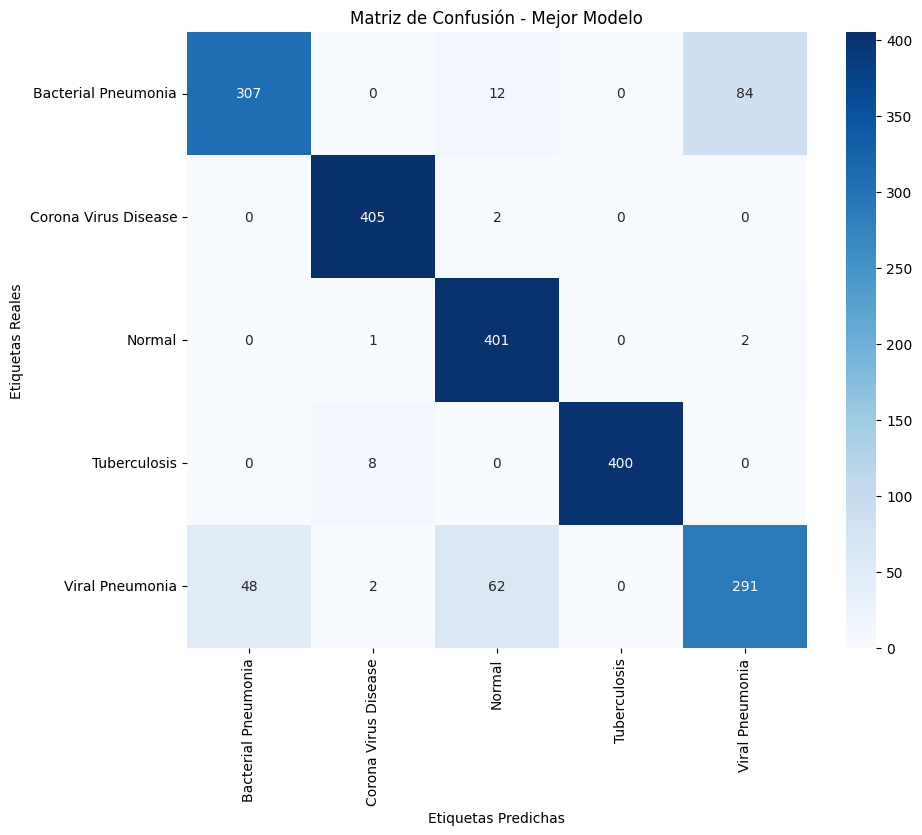

In [36]:
# Cargar el mejor modelo guardado durante el entrenamiento
best_model = tf.keras.models.load_model("best_model.keras")

# Predecir etiquetas para los datos de prueba usando el mejor modelo
y_pred = best_model.predict(test_dataset)
y_pred_bool = np.argmax(y_pred, axis=1)  # Convertir probabilidades a etiquetas de clase

# Extraer las etiquetas verdaderas del conjunto de prueba
rounded_labels = test_dataset.classes

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(rounded_labels, y_pred_bool)

# Calcular la precisión global
accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
print(f'Precisión Global: {accuracy*100:.2f}%')

# Graficar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_dataset.class_indices.keys(), 
            yticklabels=test_dataset.class_indices.keys())
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Reales')
plt.title('Matriz de Confusión - Mejor Modelo')
plt.show()

#### Curva ROC para Cada Clase

Se define y ejecuta una función que:  
- Calcula la curva ROC para cada clase y el área bajo la curva (AUC).  
- Muestra la línea de referencia del rendimiento al azar.  
Esta celda evalúa la capacidad del modelo para discriminar entre clases, proporcionando una métrica adicional de desempeño.


63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 624ms/step


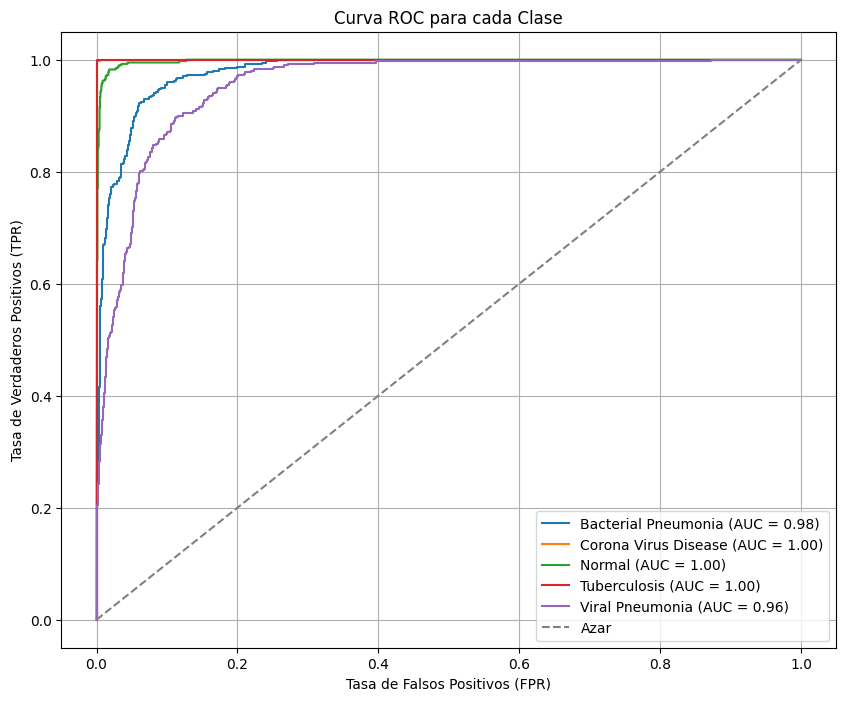

In [37]:
def plot_roc_curve(model, val_dataset):
    # Obtener las etiquetas verdaderas en formato binarizado
    y_true = label_binarize(val_dataset.classes, classes=range(5))  # Ajustar según el número de clases
    # Realizar predicciones con el modelo
    y_pred = model.predict(val_dataset)
    
    # Intentar obtener los nombres de las clases a partir del generador de datos de entrenamiento
    try:
        class_names = {v: k for k, v in train_dataset.class_indices.items()}
    except Exception:
        # Diccionario de respaldo con nombres de clases
        class_names = {
            0: "Normal",
            1: "Bacterial pneumonia",
            2: "Viral pneumonia",
            3: "Tuberculosis",
            4: "Corona virus disease"
        }
    
    plt.figure(figsize=(10, 8))
    # Para cada clase se genera su curva ROC
    for i in range(y_true.shape[1]):  
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names.get(i, "Clase " + str(i))} (AUC = {roc_auc:.2f})')
    
    # Graficar la línea de azar
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Azar')
    
    plt.title('Curva ROC para cada Clase')
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

plot_roc_curve(best_model, val_dataset)

#### Clasificación de Imágenes con Modelo Preentrenado

Se selecciona una muestra aleatoria de imágenes del conjunto de prueba y se visualizan en una cuadrícula:  
- Cada imagen se muestra junto con la etiqueta predicha y los porcentajes de probabilidad para cada clase.  
Esto facilita la interpretación de las predicciones a nivel individual y permite verificar visualmente el comportamiento del modelo.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


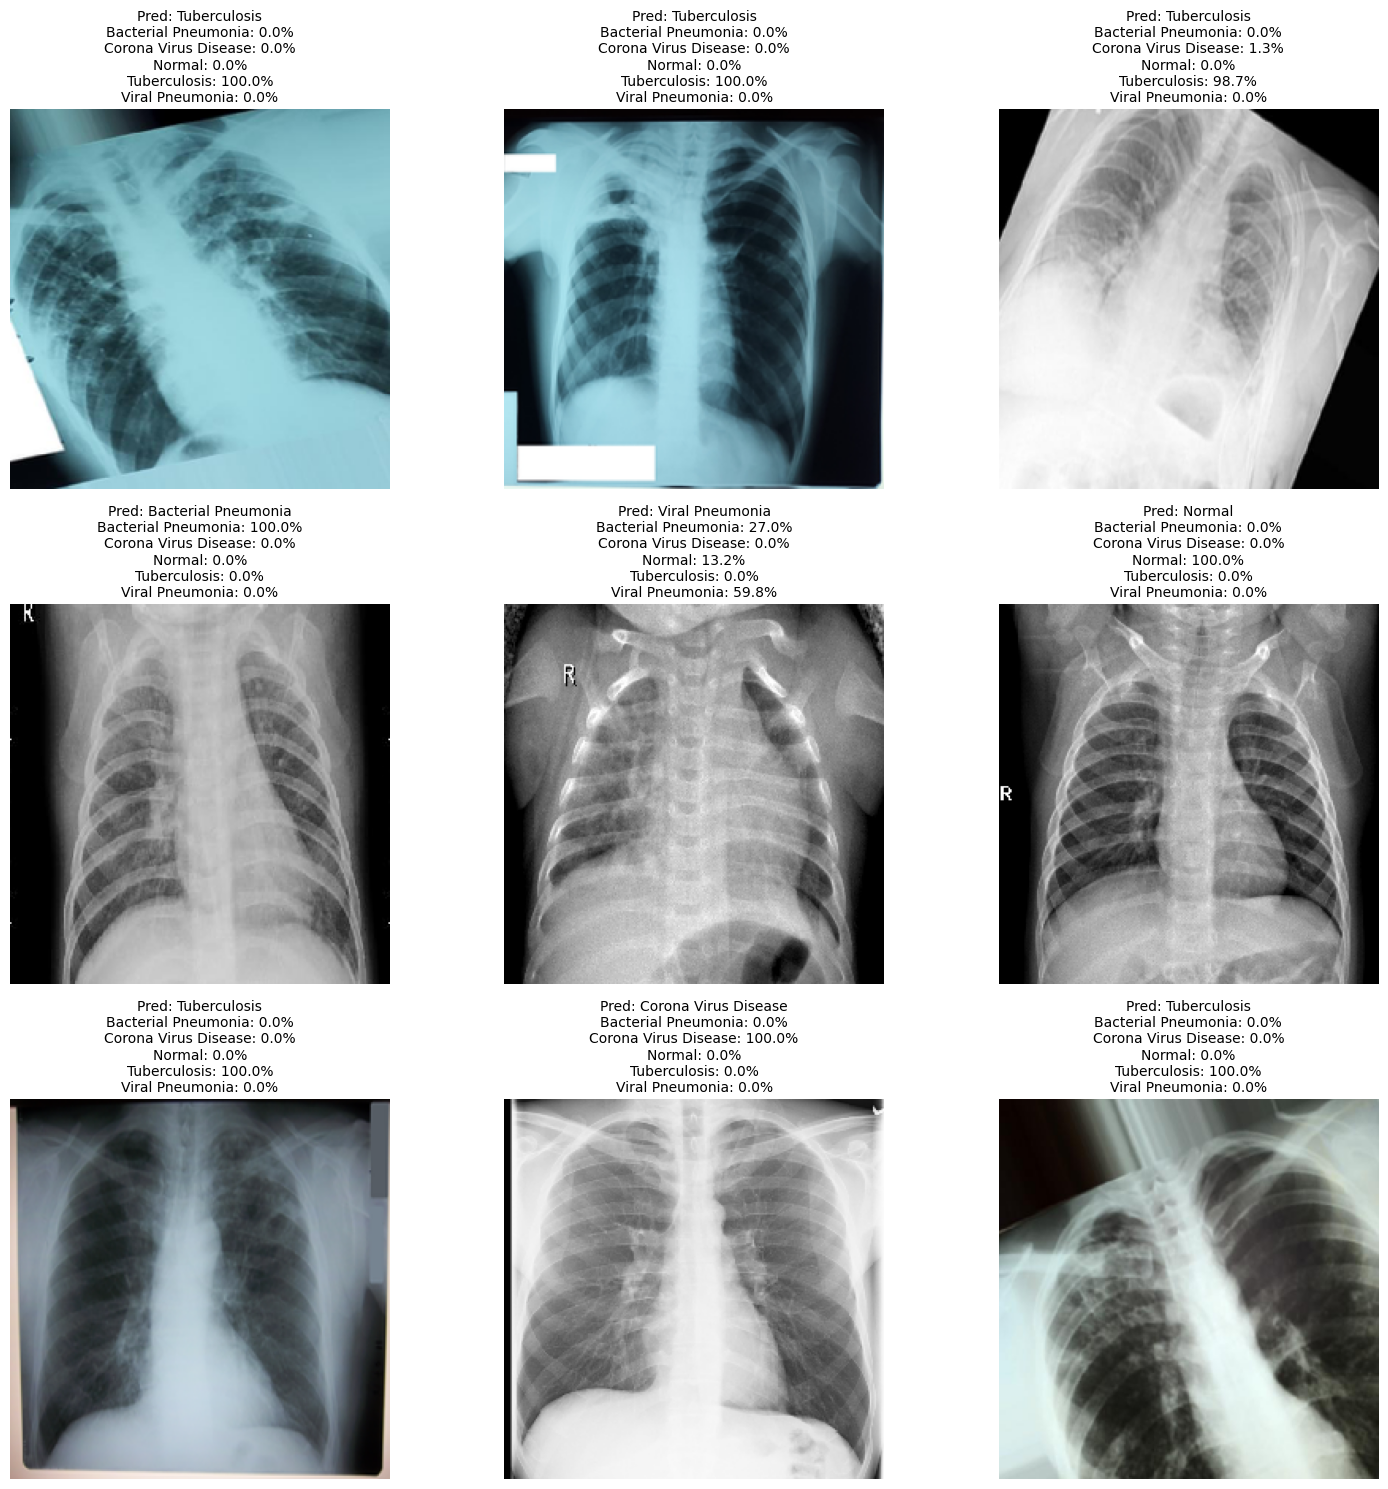

In [38]:
# Función para cargar todas las imágenes desde una carpeta
def load_all_images_from_folder(folder, target_size=(240, 240)):
    """
    Carga todas las imágenes desde la carpeta 'folder'.
    Si existen subcarpetas, se asume que cada una corresponde a una clase y se usa el nombre de la subcarpeta como etiqueta.
    Devuelve un array numpy de imágenes y un array numpy de etiquetas.
    """
    images = []
    labels = []
    
    subfolders = [os.path.join(folder, d) for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]
    
    if subfolders:
        for subfolder in subfolders:
            label = os.path.basename(subfolder)
            for file in os.listdir(subfolder):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    file_path = os.path.join(subfolder, file)
                    try:
                        img = load_img(file_path, target_size=target_size)
                        img_array = img_to_array(img)
                        images.append(img_array)
                        labels.append(label)
                    except Exception as e:
                        print(f"Error al cargar {file_path}: {e}")
    else:
        for file in os.listdir(folder):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(folder, file)
                try:
                    img = load_img(file_path, target_size=target_size)
                    img_array = img_to_array(img)
                    images.append(img_array)
                    labels.append(None)
                except Exception as e:
                    print(f"Error al cargar {file_path}: {e}")
    
    return np.array(images), np.array(labels)

# Define la ruta a la carpeta de test
test_folder = "Lung Disease Dataset/test"

# Cargar el mejor modelo guardado durante el entrenamiento
best_model = tf.keras.models.load_model("best_model.keras")

# Leer todas las imágenes de la carpeta test, barajarlas aleatoriamente y tomar una muestra
all_images, all_labels = load_all_images_from_folder(test_folder, target_size=(240, 240))
indices = np.arange(len(all_images))
np.random.shuffle(indices)
all_images = all_images[indices]
all_labels = np.array(all_labels)[indices]

# Tomar una muestra de 9 imágenes
num_samples = min(9, len(all_images))
sample_images = all_images[:num_samples]

# -- Usar una copia para preprocesar --
sample_images_preprocessed = preprocess_input(sample_images.copy())

# Obtener la asignación de índices a nombres de clase
try:
    class_names = {v: k for k, v in train_dataset.class_indices.items()}
except Exception:
    class_names = {0: "Normal", 1: "Bacterial Pneumonia", 2: "Viral Pneumonia", 3: "Tuberculosis", 4: "Corona Virus Disease"}

# Realizar predicciones con el mejor modelo usando las imágenes preprocesadas
predictions = best_model.predict(sample_images_preprocessed)
predicted_indices = np.argmax(predictions, axis=1)

# Mostrar las imágenes ORIGINALES en una cuadrícula 3x3 con la etiqueta predicha
nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < num_samples:
        # Mostrar la imagen original
        ax.imshow(sample_images[i].astype(np.uint8))

        # Obtener el vector de probabilidades para la imagen i
        probs = predictions[i]
        # Crear una lista con el porcentaje de cada clase, cada uno en una línea
        porcentajes = [f"{class_names.get(j, j)}: {p * 100:.1f}%" for j, p in enumerate(probs)]
        
        # Combinar la clase predicha y los porcentajes en el título
        title_text = f"Pred: {class_names.get(predicted_indices[i], predicted_indices[i])}\n" + "\n".join(porcentajes)
        ax.set_title(title_text, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()


#### Interfaz para predicción (el usuario elige la imagen)

In [47]:
# Cargar el modelo guardado
best_model = tf.keras.models.load_model("best_model.keras")

# Intentar obtener la asignación de índices a nombres de clase
try:
    class_names = {v: k for k, v in train_dataset.class_indices.items()}
except Exception:
    class_names = {
        0: "Normal",
        1: "Bacterial Pneumonia",
        2: "Viral Pneumonia",
        3: "Tuberculosis",
        4: "Corona Virus Disease"
    }

# Variables globales para la animación de carga
loading_running = False
animation_index = 0

def animate_loading():
    global animation_index
    if loading_running:
        dots = '.' * ((animation_index % 4))
        # Se actualiza el label con un estilo de fuente y color atractivo
        result_text.config(text="Cargando" + dots, fg="#2980b9", font=("Helvetica", 12, "italic"))
        animation_index += 1
        root.after(300, animate_loading)

# Función que se ejecuta en un hilo para procesar la predicción sin bloquear la GUI
def run_prediction(file_path):
    # Preparar la imagen para la predicción (tamaño 240x240)
    img = load_img(file_path, target_size=(240, 240))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Realizar la predicción con el modelo cargado
    predictions = best_model.predict(img_array)
    predicted_index = np.argmax(predictions, axis=1)[0]
    probs = predictions[0]
    # Crear una lista con el porcentaje de cada clase
    porcentajes = [f"{class_names.get(j, j)}: {p * 100:.1f}%" for j, p in enumerate(probs)]
    title_text = f"Pred: {class_names.get(predicted_index, predicted_index)}\n" + "\n".join(porcentajes)
    
    # Actualizar la interfaz desde el hilo principal
    def update_result():
        global loading_running
        loading_running = False
        result_text.config(text=title_text, fg="#2ecc71", font=("Helvetica", 12, "bold"), bg="#ecf0f1", padx=10, pady=10)
    root.after(0, update_result)

# Función para que el usuario suba una imagen y se procese la predicción
def upload_image():
    file_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.png;*.jpg;*.jpeg")])
    if file_path:
        # Iniciar animación de carga
        global loading_running, animation_index
        loading_running = True
        animation_index = 0
        animate_loading()
        
        # Cargar la imagen para mostrarla en la interfaz (usando PIL)
        pil_image = Image.open(file_path)
        pil_image_display = pil_image.copy()
        pil_image_display.thumbnail((400, 400))  # Redimensionar para la interfaz
        tk_image = ImageTk.PhotoImage(pil_image_display)
        image_label.config(image=tk_image)
        image_label.image = tk_image
        
        # Ejecutar la predicción en un hilo para evitar bloquear la interfaz
        threading.Thread(target=run_prediction, args=(file_path,), daemon=True).start()

# Configuración de la ventana principal
root = tk.Tk()
root.title("Clasificador de Imágenes - Predicción")
root.geometry("800x800")
root.configure(bg="#f5f7fa")

# Fuentes personalizadas
title_font = tkFont.Font(family="Helvetica", size=16, weight="bold")
label_font = tkFont.Font(family="Helvetica", size=11)

# Crear notebook para organizar la interfaz
notebook = ttk.Notebook(root)
notebook.pack(fill="both", expand=True, padx=20, pady=20)

# Pestaña para subir imagen
tab_upload = ttk.Frame(notebook)
notebook.add(tab_upload, text="Subir Imagen")

# Marco superior para el botón de subir imagen
upload_frame = tk.Frame(tab_upload, bg="#f5f7fa", padx=10, pady=10)
upload_frame.pack(fill="x")
btn_upload = tk.Button(upload_frame, text="Subir Imagen", command=upload_image,
                       font=label_font, bg="#3498db", fg="white", padx=10, pady=5)
btn_upload.pack()

# Marco para mostrar la imagen y el resultado de la predicción
result_frame = tk.Frame(tab_upload, bg="#f5f7fa", padx=10, pady=10)
result_frame.pack(fill="both", expand=True)

image_label = tk.Label(result_frame, bg="#f5f7fa")
image_label.pack(pady=10)

result_text = tk.Label(result_frame, bg="#f5f7fa", font=label_font, justify="left")
result_text.pack(pady=10)

root.mainloop()

### Regresión Polinomial

En esta sección se realiza el siguiente flujo de trabajo:

- **Extracción de Características:**  
  Se obtienen las características reales de las imágenes del conjunto de prueba utilizando el modelo entrenado, aprovechando la salida de la capa intermedia denominada **"features"** para representar cada imagen.

- **Evaluación de la Capacidad Predictiva:**  
  Para cada dimensión de la representación, se evalúa su capacidad para predecir el índice de clase mediante una regresión polinómica de grado 4.

- **Selección de la Mejor Característica:**  
  Se identifica la dimensión que presenta la mayor correlación con el índice de clase, determinada por el mayor coeficiente R².

- **Ajuste del Modelo de Regresión:**  
  Con la característica seleccionada, se ajusta un modelo de regresión polinómica sobre los datos de prueba.

- **Evaluación del Desempeño:**  
  Se calculan métricas de rendimiento como el error cuadrático medio (MSE) y el R² score para evaluar la precisión del modelo.

- **Visualización:**  
  Se genera un gráfico de dispersión que muestra la relación entre el índice de clase y el valor de la característica, junto con la curva de regresión polinómica ajustada.

Found 2025 images belonging to 5 classes.
Mapping de clases: {0: 'Bacterial Pneumonia', 1: 'Corona Virus Disease', 2: 'Normal', 3: 'Tuberculosis', 4: 'Viral Pneumonia'}
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 687ms/step
La mejor característica es la dimensión 179 con R² = 0.9554
MSE: 0.0318, R²: 0.9554


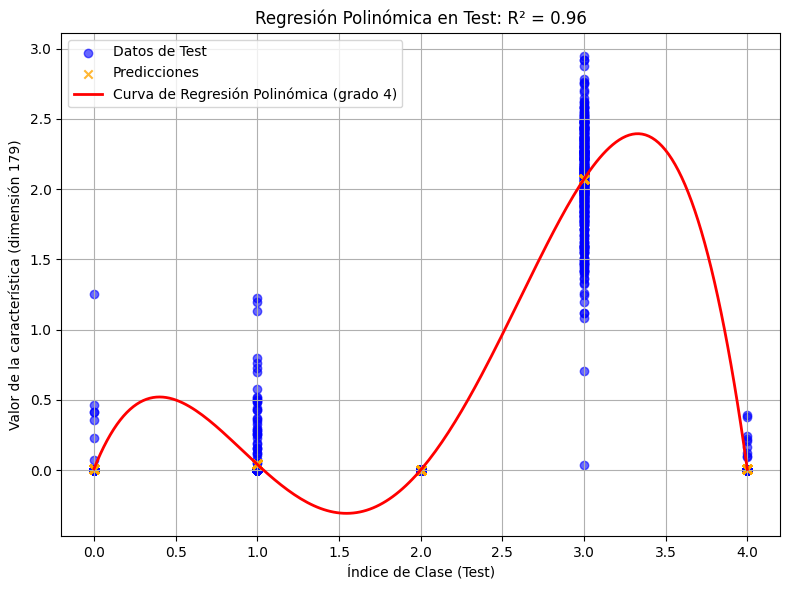

In [40]:
# Parámetros
image_size = (240, 240)  
batch_size = 32

# 1. Crear el generador de datos de prueba y cargar test_dataset
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
test_dataset = test_datagen.flow_from_directory(
    'Lung Disease Dataset/test',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Obtener las etiquetas verdaderas (índices de clase) del conjunto de prueba
y_true = test_dataset.classes  # Array de enteros (0,1,2,3,4)

# Obtener el mapeo de clases automáticamente a partir del generador
# test_dataset.class_indices es un diccionario {nombre_clase: índice}
class_names_from_data = {v: k for k, v in test_dataset.class_indices.items()}
print("Mapping de clases:", class_names_from_data)

# 2. Cargar el mejor modelo entrenado y crear extractor de features
best_model = tf.keras.models.load_model("best_model.keras")
feature_extractor = Model(
    inputs=best_model.input,
    outputs=best_model.get_layer("features").output
)
# Extraer las features del conjunto de prueba
features_test = feature_extractor.predict(test_dataset)

# 3. Buscar la mejor característica (la que obtiene mayor R² usando un polinomio de grado 4)
num_features = features_test.shape[1]
best_feat = 0
best_r2 = -np.inf

for i in range(num_features):
    feat_i = features_test[:, i].reshape(-1, 1)
    # Usamos el índice de clase (0,1,2,3,4) como variable independiente
    X = y_true.reshape(-1, 1).astype(float)
    Y = feat_i.flatten()
    
    poly = PolynomialFeatures(degree=4)
    X_poly = poly.fit_transform(X)
    
    lin_reg = LinearRegression()
    lin_reg.fit(X_poly, Y)
    Y_pred = lin_reg.predict(X_poly)
    
    current_r2 = r2_score(Y, Y_pred)
    if current_r2 > best_r2:
        best_r2 = current_r2
        best_feat = i

print(f"La mejor característica es la dimensión {best_feat} con R² = {best_r2:.4f}")

# 4. Ajustar la regresión polinómica (grado 4) con los datos de prueba para la mejor característica
X = y_true.reshape(-1, 1).astype(float)
Y = features_test[:, best_feat].flatten()

poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X)

lin_reg = LinearRegression()
lin_reg.fit(X_poly, Y)
Y_pred = lin_reg.predict(X_poly)

mse_val = mean_squared_error(Y, Y_pred)
r2_val = r2_score(Y, Y_pred)
print(f"MSE: {mse_val:.4f}, R²: {r2_val:.4f}")

# 5. Crear una malla densa para graficar la curva suavemente
X_dense = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
X_dense_poly = poly.transform(X_dense)
Y_dense = lin_reg.predict(X_dense_poly)

# 6. Graficar los datos y la curva de regresión, mostrando también los puntos predichos
plt.figure(figsize=(8,6))
# Puntos reales de Test
plt.scatter(X, Y, color='blue', alpha=0.6, label='Datos de Test')
# Puntos predichos sobre los mismos datos
plt.scatter(X, Y_pred, color='orange', alpha=0.8, marker='x', label='Predicciones')
# Curva suave de la regresión
plt.plot(X_dense, Y_dense, 'r-', linewidth=2, label='Curva de Regresión Polinómica (grado 4)')

plt.xlabel("Índice de Clase (Test)")
plt.ylabel(f"Valor de la característica (dimensión {best_feat})")
plt.title(f"Regresión Polinómica en Test: R² = {r2_val:.2f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Agrupamiento (Clustering) con K-Means Basado en las 5 Clases y Visualización

Se aplican técnicas de reducción de dimensionalidad y clustering para analizar la organización de las imágenes en el espacio de características:  
- Se utiliza PCA para reducir la dimensionalidad a 2 componentes, facilitando la visualización.  
- Se emplea K-Means para agrupar las imágenes en clusters.  
- Se grafican los clusters junto con los centros de cluster y se identifica la clase mayoritaria en cada uno.  
Esta celda ofrece una visión intuitiva de cómo se agrupan las imágenes según las características aprendidas.


64/64 ━━━━━━━━━━━━━━━━━━━━ 37s 585ms/step


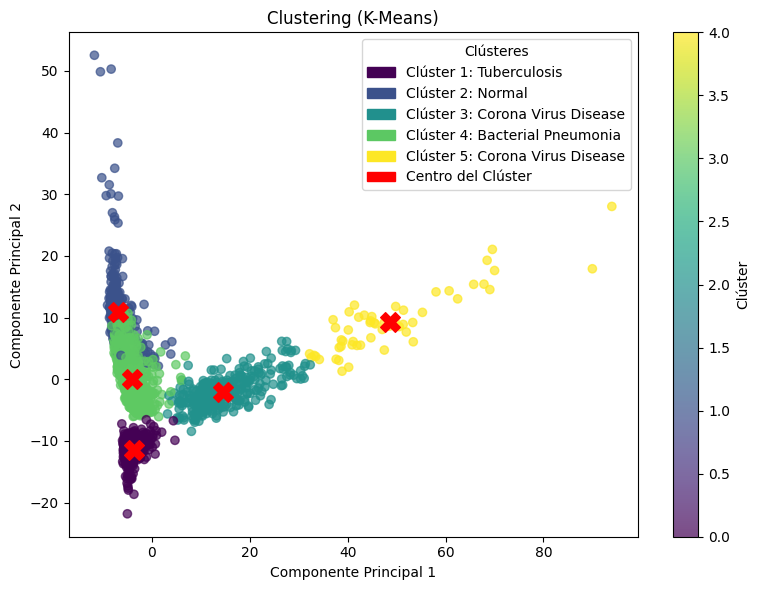

In [41]:
# Extraer características del conjunto de prueba usando el extractor
features_nn = feature_extractor.predict(test_dataset)

# Obtener las etiquetas verdaderas del conjunto de prueba (como un array numérico)
y_true_reg = test_dataset.labels

# 1. Reducir la dimensionalidad para graficar (2D)
pca = PCA(n_components=2)
features_2d_nn = pca.fit_transform(features_nn)

# 2. Clustering con K-Means
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(features_nn)

# 3. Graficar en un solo subplot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_2d_nn[:, 0], features_2d_nn[:, 1],
                      c=clusters, cmap='viridis', alpha=0.7)
plt.title("Clustering (K-Means)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")

cbar = plt.colorbar(scatter)
cbar.set_label("Clúster")

# 4. Dibujar centros de cluster
centers = kmeans.cluster_centers_
centers_2d = pca.transform(centers)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1],
            c='red', marker='X', s=200, label='Centro del Clúster')

# 5. Obtener la clase mayoritaria en cada cluster
unique_clusters = np.unique(clusters)
cluster_majority = {}
for cl in unique_clusters:
    indices = np.where(clusters == cl)[0]
    if len(indices) > 0:
        # Clase más frecuente en ese cluster
        majority_label = Counter(y_true_reg[indices]).most_common(1)[0][0]
        cluster_majority[cl] = majority_label

# 6. Construir la leyenda sin repetir clases
handles_cluster = []
used_labels = set()

for cl in unique_clusters:
    # Color para este cluster
    norm_val = (cl - unique_clusters.min()) / (unique_clusters.max() - unique_clusters.min() + 1e-8)
    color = plt.cm.viridis(norm_val)

    # Nombre de la clase mayoritaria
    label_name = class_names.get(cluster_majority[cl], cluster_majority[cl])

    used_labels.add(label_name)
    patch = mpatches.Patch(color=color, label=f"Clúster {cl+1}: {label_name}")
    handles_cluster.append(patch)

# Agregar patch para "Centro del Cluster"
center_patch = mpatches.Patch(color='red', label="Centro del Clúster")
handles_cluster.append(center_patch)

plt.legend(handles=handles_cluster, title="Clústeres", loc='best')
plt.tight_layout()
plt.show()


#### Extracción de Características Radiomics

Esta sección de código se encarga de:
- **Extraer características radiomics** de imágenes del dataset de enfermedades pulmonares, utilizando el paquete *PyRadiomics*.
- **Procesar el dataset**: se definen funciones para convertir imágenes a escala de grises, generar máscaras dummy y extraer características de cada imagen organizada por clase.
- **Seleccionar características relevantes**: se aplica la prueba de Kruskal-Wallis para comparar cada característica entre clases y se ajustan los p-values mediante el método de Benjamini-Hochberg, seleccionando las 10 mejores características.
- **Entrenar y evaluar un clasificador basado en Regresión Logística**: se utiliza un Pipeline que incluye normalización (StandardScaler) y Regresión Logística, mostrando métricas como *accuracy*, *precision*, *recall* y *F1-score*.

Esta sección integra todo el flujo de procesamiento y análisis de imágenes mediante radiomics, desde la extracción de características hasta la evaluación del rendimiento del clasificador.

Total de imágenes procesadas en entrenamiento: 6054
Dimensión de las características de entrenamiento: (6054, 93)

                                     10 mejores características                                     
 1. original_firstorder_10Percentile                   (Familia: Escala de grises)
 2. original_glcm_MCC                                  (Familia: Matriz de Co-ocurrencia de Niveles de Gris)
 3. original_glcm_SumEntropy                           (Familia: Matriz de Co-ocurrencia de Niveles de Gris)
 4. original_gldm_DependenceEntropy                    (Familia: Matriz de Dependencia de Niveles de Gris)
 5. original_gldm_DependenceNonUniformity              (Familia: Matriz de Dependencia de Niveles de Gris)
 6. original_gldm_DependenceNonUniformityNormalized    (Familia: Matriz de Dependencia de Niveles de Gris)
 7. original_gldm_DependenceVariance                   (Familia: Matriz de Dependencia de Niveles de Gris)
 8. original_gldm_LargeDependenceEmphasis              

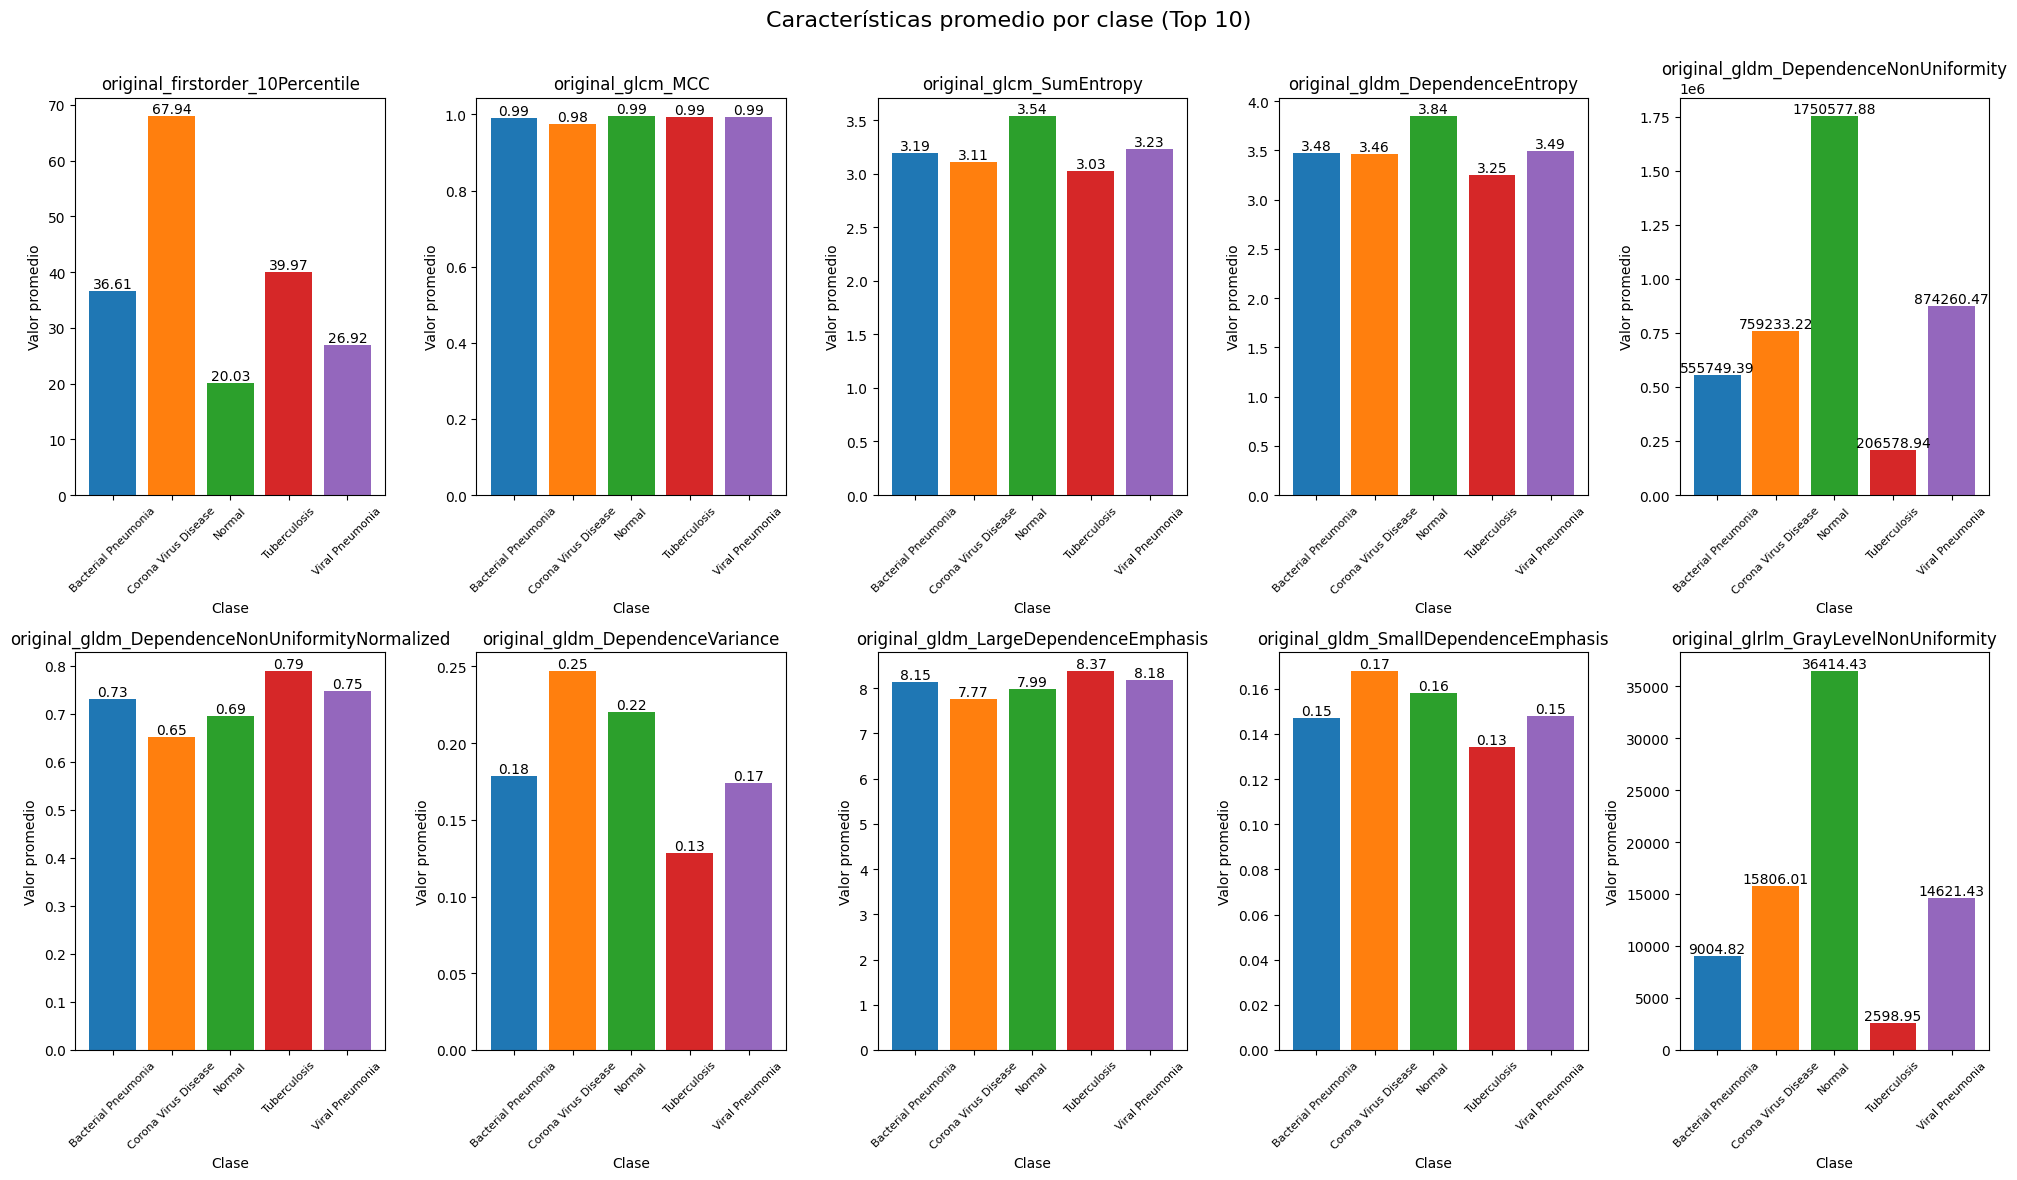

In [42]:
# Diccionario personalizado para traducir los nombres de las familias a español
custom_descriptions = {
    "firstorder": "Escala de grises",
    "shape": "Morfología",
    "glcm": "Matriz de Co-ocurrencia de Niveles de Gris",
    "glrlm": "Matriz de Longitud de Corridas en Niveles de Gris",
    "gldm": "Matriz de Dependencia de Niveles de Gris",
    "glszm": "Matriz de Tamaño de Zonas en Niveles de Gris",
    "ngtdm": "Matriz de Diferencia de Tonos de Gris en Vecindad"
}

# Variable global para almacenar las clases de características
_featureClasses = None

def getFeatureClasses():
    """
    Itera sobre todos los módulos del paquete radiomics utilizando pkgutil e importa posteriormente esos módulos.

    Devuelve un diccionario de todos los módulos que contienen las featureClasses, con el nombre del módulo como clave y el objeto de la clase abstracta de la featureClass como valor. Se asume que existe solo una featureClass por módulo.

    Esto se logra mediante inspect.getmembers. Se añaden los módulos si contienen un miembro que es una clase, cuyo nombre comienza con 'Radiomics' y que hereda de :py:class:`radiomics.base.RadiomicsFeaturesBase`.

    Esta iteración se ejecuta solo una vez (durante la inicialización de la toolbox); las llamadas subsiguientes retornan el diccionario creado en la primera llamada.
    """
    global _featureClasses
    if _featureClasses is None:  
        _featureClasses = {}
        # Usar la ruta interna del paquete radiomics para iterar sus módulos
        base_dir = radiomics.__path__[0]
        for _, mod, _ in pkgutil.iter_modules([base_dir]):
            if str(mod).startswith('_'):  # Omitir módulos "privados"
                continue
            try:
                __import__('radiomics.' + mod)
            except Exception as import_error:
                print(f"Error al importar el módulo radiomics.{mod}: {import_error}")
                continue
            module = sys.modules.get('radiomics.' + mod)
            if module is None:
                continue
            attributes = inspect.getmembers(module, inspect.isclass)
            for a in attributes:
                if a[0].startswith('Radiomics'):
                    # Incluir solo clases que hereden de RadiomicsFeaturesBase
                    for parentClass in inspect.getmro(a[1])[1:]:
                        if parentClass.__name__ == 'RadiomicsFeaturesBase':
                            _featureClasses[mod] = a[1]
                            break

    return _featureClasses

# Cargar la información de características a partir de getFeatureClasses
feature_info = {}
try:
    features_dict = getFeatureClasses()
    for feature_family, feature_class in features_dict.items():
        if hasattr(feature_class, '__doc__') and feature_class.__doc__:
            feature_info[feature_family.lower()] = {"description": feature_class.__doc__.strip()}
        else:
            feature_info[feature_family.lower()] = {"description": feature_family}
except Exception as e:
    print(f"No se pudo cargar la información de características: {e}")
    print("Se usará el nombre de la familia.")

def get_feature_family_description(feature_key):
    """
    Extrae la familia de la característica a partir de su nombre y devuelve
    la descripción en español si se encuentra en el diccionario de traducciones,
    o la descripción oficial si no existe la traducción.
    Se asume que el nombre tiene el formato "original_<familia>_<nombre>".
    """
    parts = feature_key.split("_")
    if len(parts) >= 3:
        family = parts[1].lower()
        # Primero, intentar obtener la traducción personalizada en español
        if family in custom_descriptions:
            return custom_descriptions[family]
        # Si no se encuentra, intentar obtener la descripción cargada del docstring
        if family in feature_info and "description" in feature_info[family]:
            return feature_info[family]["description"]
        else:
            return family
    else:
        return "Desconocida"

# Configuración del extractor: forzar 2D y desactivar características de "shape"
settings = {
    'force2D': True,
    'featureClasses': {
        'shape': False
    }
}
extractor = featureextractor.RadiomicsFeatureExtractor(**settings)

# Variable global para almacenar el orden de las características
feature_names = []

def convert_image_to_grayscale(input_path, output_path):
    """
    Convierte la imagen en input_path a escala de grises (si es multicanal)
    y la castea a UInt8, guardándola en output_path.
    """
    image = sitk.ReadImage(input_path)
    if image.GetNumberOfComponentsPerPixel() > 1:
        image = sitk.VectorIndexSelectionCast(image, 0)
    image = sitk.Cast(image, sitk.sitkUInt8)
    sitk.WriteImage(image, output_path)

def generate_dummy_mask(image, output_path):
    """
    A partir de una imagen SimpleITK (ya convertida a escala de grises y UInt8),
    genera una máscara binaria (todos los píxeles en 1) y la guarda en output_path.
    """
    array = sitk.GetArrayFromImage(image)
    mask_array = np.ones(array.shape, dtype=np.uint8)
    mask = sitk.GetImageFromArray(mask_array, isVector=False)
    mask.CopyInformation(image)
    sitk.WriteImage(mask, output_path)

def process_dataset(data_folder, max_images=None, randomize=False):
    """
    Procesa las imágenes de un dataset organizado en carpetas (cada carpeta es una clase).
    Extrae las características usando radiomics y retorna arrays de características y etiquetas.
    """
    global feature_names
    feature_list = []
    label_list = []
    
    if randomize:
        # Recopilar todos los archivos (con su clase) en una lista
        entries = []
        for class_name in os.listdir(data_folder):
            class_dir = os.path.join(data_folder, class_name)
            if os.path.isdir(class_dir):
                for file in os.listdir(class_dir):
                    if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                        entries.append((class_name, os.path.join(class_dir, file)))
        if max_images is not None:
            if len(entries) < max_images:
                print(f"Advertencia: Solo se encontraron {len(entries)} imágenes en {data_folder}")
                selected_entries = entries
            else:
                selected_entries = random.sample(entries, max_images)
        else:
            random.shuffle(entries)
            selected_entries = entries
        
        for class_name, image_path in selected_entries:
            # Crear archivo temporal para la imagen convertida
            temp_image = tempfile.NamedTemporaryFile(suffix=".nii.gz", delete=False)
            temp_image_name = temp_image.name
            temp_image.close()
            convert_image_to_grayscale(image_path, temp_image_name)
            
            # Crear archivo temporal para la máscara
            temp_mask = tempfile.NamedTemporaryFile(suffix=".nii.gz", delete=False)
            temp_mask_name = temp_mask.name
            temp_mask.close()
            converted_image = sitk.ReadImage(temp_image_name)
            generate_dummy_mask(converted_image, temp_mask_name)
            
            try:
                # Extraer características usando la imagen convertida y la máscara
                features = extractor.execute(temp_image_name, temp_mask_name)
                feature_vector = []
                if not feature_names:
                    # Se asume que se extraen solo las características "original"
                    feature_names = [key for key in features.keys() if key.startswith("original")]
                for key in feature_names:
                    try:
                        feature_vector.append(float(features[key]))
                    except Exception as e:
                        print(f"No se pudo convertir la característica {key}: {e}")
                if feature_vector:
                    feature_list.append(feature_vector)
                    label_list.append(class_name)
                else:
                    print(f"No se extrajeron características para: {image_path}")
            except Exception as e:
                print(f"Error al extraer características de {image_path}: {e}")
            finally:
                if os.path.exists(temp_image_name):
                    os.remove(temp_image_name)
                if os.path.exists(temp_mask_name):
                    os.remove(temp_mask_name)
    else:
        # Procesar todas las imágenes en cada subcarpeta (para entrenamiento o test completo)
        for class_name in os.listdir(data_folder):
            class_dir = os.path.join(data_folder, class_name)
            if os.path.isdir(class_dir):
                for file in os.listdir(class_dir):
                    if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                        image_path = os.path.join(class_dir, file)
                        
                        temp_image = tempfile.NamedTemporaryFile(suffix=".nii.gz", delete=False)
                        temp_image_name = temp_image.name
                        temp_image.close()
                        convert_image_to_grayscale(image_path, temp_image_name)
                        
                        temp_mask = tempfile.NamedTemporaryFile(suffix=".nii.gz", delete=False)
                        temp_mask_name = temp_mask.name
                        temp_mask.close()
                        converted_image = sitk.ReadImage(temp_image_name)
                        generate_dummy_mask(converted_image, temp_mask_name)
                        
                        try:
                            features = extractor.execute(temp_image_name, temp_mask_name)
                            feature_vector = []
                            if not feature_names:
                                feature_names = [key for key in features.keys() if key.startswith("original")]
                            for key in feature_names:
                                try:
                                    feature_vector.append(float(features[key]))
                                except Exception as e:
                                    print(f"No se pudo convertir la característica {key}: {e}")
                            if feature_vector:
                                feature_list.append(feature_vector)
                                label_list.append(class_name)
                            else:
                                print(f"No se extrajeron características para: {image_path}")
                        except Exception as e:
                            print(f"Error al extraer características de {image_path}: {e}")
                        finally:
                            if os.path.exists(temp_image_name):
                                os.remove(temp_image_name)
                            if os.path.exists(temp_mask_name):
                                os.remove(temp_mask_name)
    
    return np.array(feature_list), np.array(label_list)

# Rutas de los datasets
train_folder = 'Lung Disease Dataset/train'
test_folder = 'Lung Disease Dataset/test'

# Procesar el conjunto de entrenamiento (todas las imágenes por subcarpeta)
X_train, y_train = process_dataset(train_folder, randomize=False)
print("Total de imágenes procesadas en entrenamiento:", len(y_train))
print("Dimensión de las características de entrenamiento:", X_train.shape)

# ------------------------- #
# Selección de características mediante análisis estadístico
# Se utiliza la prueba de Kruskal-Wallis para comparar cada característica entre las clases.
# ------------------------- #
unique_classes = np.unique(y_train)

p_values = []
for i, feature in enumerate(feature_names):
    groups = [X_train[y_train == cls, i] for cls in unique_classes]
    stat, p = kruskal(*groups)
    p_values.append(p)

p_values = np.array(p_values)

# Ajustar los p-values utilizando Benjamini-Hochberg (FDR)
rej, pvals_corr, alphacSidak, alphacBonf = multipletests(p_values, alpha=0.05, method='fdr_bh')

# Seleccionar las 10 mejores características según el p-value ajustado (menor es mejor)
selected_indices = np.argsort(pvals_corr)[:10]
selected_features_names = [feature_names[i] for i in selected_indices]

print("\n" + "="*100)
print("{:^100}".format("10 mejores características"))
print("="*100)
for i, feat in enumerate(selected_features_names, start=1):
    # Obtener la descripción oficial de la familia en español
    family_desc = get_feature_family_description(feat)
    print("{:2d}. {:<50} (Familia: {})".format(i, feat, family_desc))
print("="*100 + "\n")

# Reducir los conjuntos de datos a las características seleccionadas
X_train_selected = X_train[:, selected_indices]

# Visualizar características promedio por clase para las 10 mejores características
df_train_selected = pd.DataFrame(X_train_selected, columns=selected_features_names)
df_train_selected['Clase'] = y_train
centroids_selected = df_train_selected.groupby('Clase').mean()
print("\n" + "=" * 60)
print("Características promedio por clase (Top 10)")
print("=" * 60)
for clase, fila in centroids_selected.iterrows():
    print(f"\nClase: {clase}")
    for feature in centroids_selected.columns:
        print(f"{feature}: {fila[feature]:.4f}\n")
print("=" * 60 + "\n")

# Procesar el conjunto de prueba completo en orden aleatorio
X_test, y_test = process_dataset(test_folder, max_images=None, randomize=True)
print("Total de imágenes procesadas en prueba:", len(y_test))
print("Dimensión de las características de prueba:", X_test.shape)

# Reducir el conjunto de prueba a las características seleccionadas
X_test_selected = X_test[:, selected_indices]

# Codificar las etiquetas
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# ------------------------- #
# Clasificación con Regresión Logística
# ------------------------- #
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(max_iter=1000))
])

# Entrenar la regresión logística con las características seleccionadas
logreg_pipeline.fit(X_train_selected, y_train)
y_pred_logreg = logreg_pipeline.predict(X_test_selected)

# Calcular métricas de rendimiento
accuracy_val = accuracy_score(y_test, y_pred_logreg)
precision_val = precision_score(y_test, y_pred_logreg, average="weighted")
recall_val = recall_score(y_test, y_pred_logreg, average="weighted")
f1_val = f1_score(y_test, y_pred_logreg, average="weighted")

print("\nMétricas del clasificador de Regresión Logística con las 10 mejores características:")
print(f" Accuracy:  {accuracy_val:.4f}")
print(f" Precision: {precision_val:.4f}")
print(f" Recall:    {recall_val:.4f}")
print(f" F1-Score:  {f1_val:.4f}")

# ------------------------- #
# Gráfico comparativo: Características promedio por clase (Top 10) - Gráfico de barras
# ------------------------- #
# Número de características
num_features = len(centroids_selected.columns)
fig, axes = plt.subplots(2, 5, figsize=(20, 12))
axes = axes.flatten()

# Paleta de colores: se utilizarán colores distintos para cada clase
num_clases = len(centroids_selected.index)
base_colors = plt.cm.tab10.colors  
if num_clases > len(base_colors):
    colors = plt.cm.rainbow(np.linspace(0, 1, num_clases))
else:
    colors = base_colors[:num_clases]

for idx, feature in enumerate(centroids_selected.columns):
    ax = axes[idx]
    clases = centroids_selected.index
    valores = centroids_selected[feature].values

    # Crear gráfico de barras con un color diferente para cada clase
    bars = ax.bar(range(len(clases)), valores, color=colors)

    # Agregar etiquetas con dos decimales sobre cada barra
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}",
                ha='center', va='bottom', fontsize=10)

    # Configurar ejes
    ax.set_xticks(range(len(clases)))
    ax.set_xticklabels(clases, rotation=45, fontsize=8)
    ax.set_title(feature, fontsize=12)
    ax.set_xlabel("Clase", fontsize=10)
    ax.set_ylabel("Valor promedio", fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Características promedio por clase (Top 10)", fontsize=16)
plt.show()

#### Visualización de manera gráfica de la Regresión

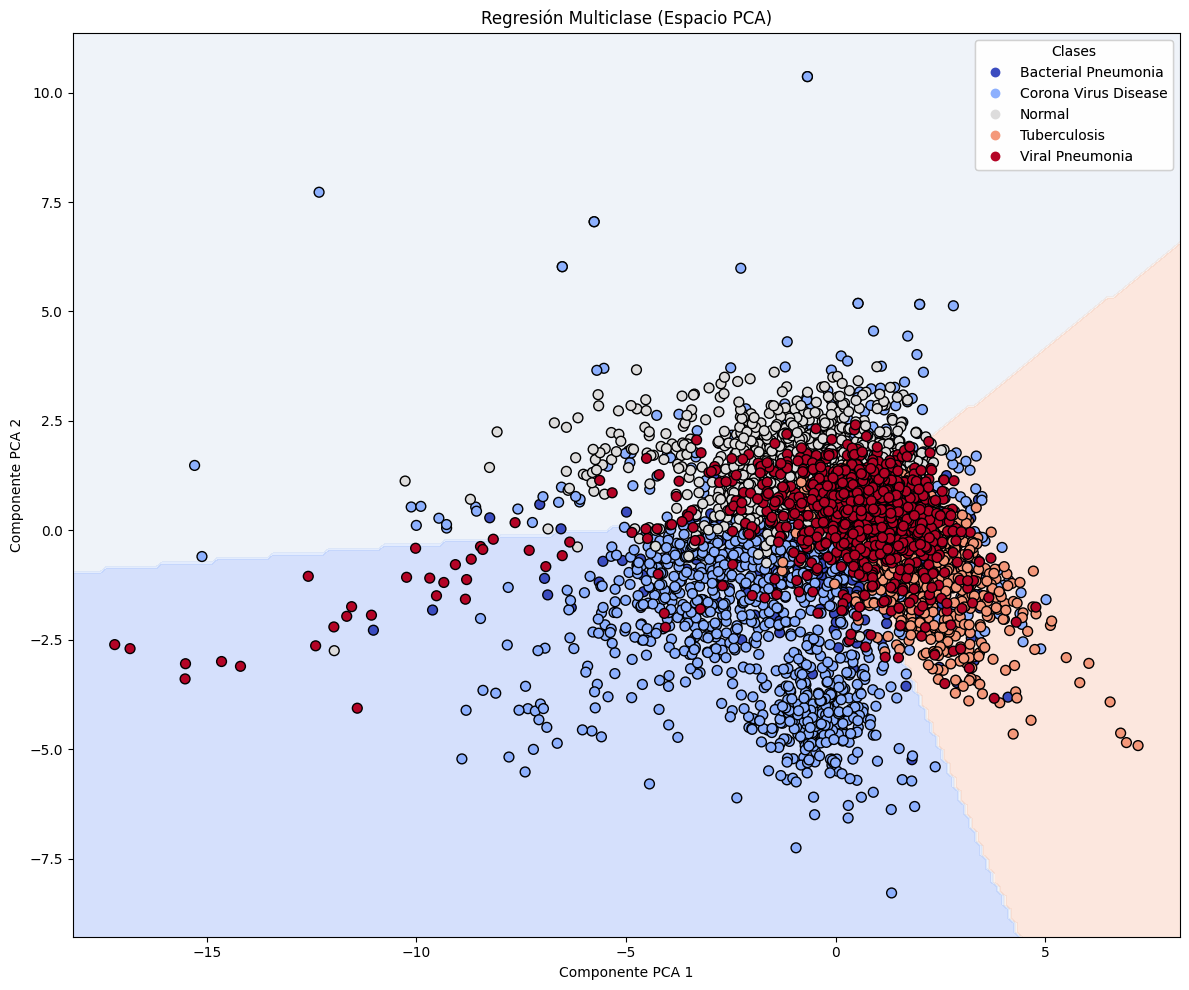

In [43]:
# Escalar los datos con las características seleccionadas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Reducir la dimensionalidad a 2 componentes usando PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Entrenar la Regresión Logística sobre el espacio reducido
# Ya que X_train_pca está escalado, no es necesario volver a escalar
logreg_pca = LogisticRegression(max_iter=1000)
logreg_pca.fit(X_train_pca, y_train)

# Crear una malla para trazar las fronteras de decisión
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Predecir la clase para cada punto de la malla
Z = logreg_pca.predict(np.c_[xx.ravel(), yy.ravel()])

# Convertir las etiquetas predichas (cadenas) a valores numéricos para la gráfica
Z_numeric = le.transform(Z)
Z_numeric = Z_numeric.reshape(xx.shape)

# Graficar las fronteras de decisión y los puntos de entrenamiento
plt.figure(figsize=(12, 10))
plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap=plt.cm.coolwarm)

# Codificar las etiquetas de entrenamiento para la gráfica
y_train_encoded = le.transform(y_train)
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
                      c=y_train_encoded, cmap=plt.cm.coolwarm,
                      edgecolors='k', s=50)

plt.xlabel("Componente PCA 1")
plt.ylabel("Componente PCA 2")
plt.title("Regresión Multiclase (Espacio PCA)")

# Crear leyenda usando las clases originales
handles, _ = scatter.legend_elements()
legend1 = plt.legend(handles, le.classes_, title="Clases")
plt.gca().add_artist(legend1)

plt.tight_layout()
plt.show()

#### Comparación de Métricas: EfficientNetB1 vs Radiomics

Esta sección se encarga de comparar visualmente los resultados obtenidos por dos enfoques de clasificación:
- **Modelo de Deep Learning**, que utiliza EfficientNetB1 para la clasificación de imágenes. Las métricas se extraen a partir del classification report (se emplea el macro avg para precisión, recall y F1-score, y se utiliza la accuracy global).
- **Clasificador Radiomics**, que extrae características radiomics y utiliza un clasificador basado en SVM. Se utilizan las métricas globales calculadas directamente (accuracy, precision, recall y F1-score).

Se generan gráficos comparativos de estas métricas globales para evaluar el rendimiento de cada método.

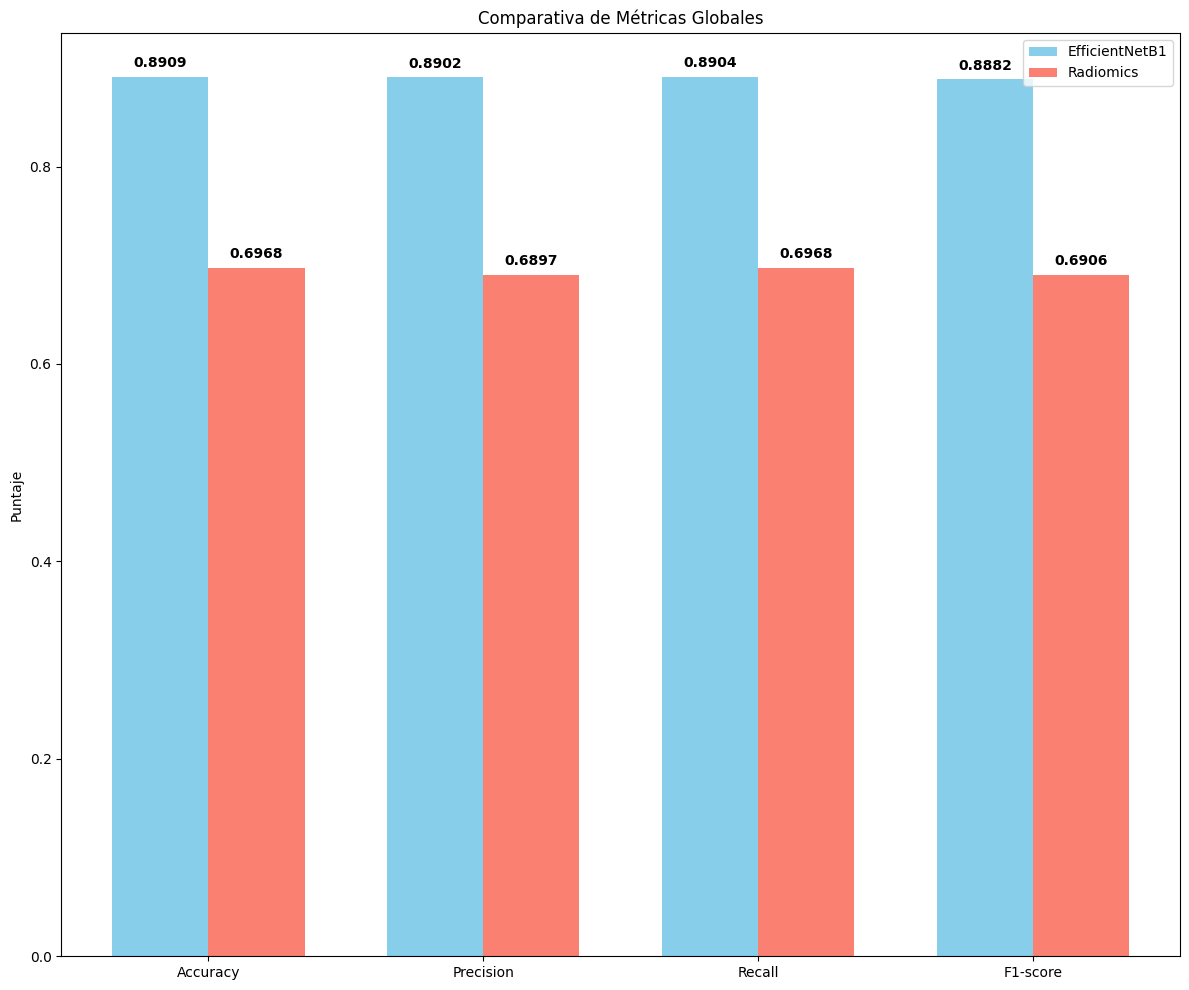

In [44]:
# Genera el classification report para el modelo Deep Learning (EfficientNetB1)
report_dl = classification_report(true_labels, y_pred_bool, digits=4, output_dict=True)
df_dl = pd.DataFrame(report_dl).transpose()

# Construir las métricas globales para Deep Learning
overall_dl = {
    'accuracy': report_dl['accuracy'],
    'precision': df_dl.loc["macro avg", "precision"],
    'recall': df_dl.loc["macro avg", "recall"],
    'f1-score': df_dl.loc["macro avg", "f1-score"]
}
overall_dl = pd.Series(overall_dl)

# Para el modelo Radiomics, utilizar las métricas calculadas directamente:
overall_rad = pd.Series({
    'accuracy': accuracy_val,
    'precision': precision_val,
    'recall': recall_val,
    'f1-score': f1_val
})

# Definir las métricas a comparar
metrics = ['accuracy', 'precision', 'recall', 'f1-score']
x = np.arange(len(metrics))
width = 0.35

# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(12, 10))
bars_dl = ax.bar(x - width/2, overall_dl[metrics].values, width, label='EfficientNetB1', color='skyblue')
bars_rad = ax.bar(x + width/2, overall_rad[metrics].values, width, label='Radiomics', color='salmon')

# Agregar los valores encima de las barras
for bars in [bars_dl, bars_rad]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # Desplazamiento hacia arriba
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Configuración del gráfico
ax.set_xticks(x)
ax.set_xticklabels([m.capitalize() for m in metrics])
ax.set_title("Comparativa de Métricas Globales")
ax.set_ylabel("Puntaje")
ax.legend()

plt.tight_layout()
plt.show()
